In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

## import numpy as np # linear algebra
## import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

## import os
## for dirname, _, filenames in os.walk('/kaggle/input'):
##    for filename in filenames:
##        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
from collections import Counter

data_dir = '/kaggle/input/fine-grained-fruit-quality-assessment/train/train'

class_counts = {}

for class_name in os.listdir(data_dir):
    class_folder = os.path.join(data_dir, class_name)
    if os.path.isdir(class_folder):
        num_images = len(os.listdir(class_folder))
        class_counts[class_name] = num_images

total_images = sum(class_counts.values())

class_proportions = {class_name: count / total_images for class_name, count in class_counts.items()}

print("Class Proportions:")
for class_name, proportion in class_proportions.items():
    print(f"{class_name}: {proportion:.2f}")


Class Proportions:
tomato_fully_ripened: 0.01
tomato_half_ripened: 0.01
banana_overripe: 0.21
banana_rotten: 0.30
banana_unripe: 0.21
banana_ripe: 0.22
tomato_green: 0.05


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
import random

#resizing
IMG_SIZE = (224, 224)
#scaling and splits
data = ImageDataGenerator(rescale=1./255, validation_split=0.2)#stratified splits for unbalanced data

trainData = data.flow_from_directory(
    '/kaggle/input/fine-grained-fruit-quality-assessment/train/train',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='sparse',#uses label encoding
    shuffle=True,
    subset='training'
)

valData = data.flow_from_directory(
    '/kaggle/input/fine-grained-fruit-quality-assessment/train/train',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='sparse',
    shuffle=False,
    subset='validation'
)

testData = data.flow_from_directory(
    '/kaggle/input/fine-grained-fruit-quality-assessment/test',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='sparse',
    shuffle=False
)


#........................


# augmentor = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# input_base_dir = '/kaggle/input/fine-grained-fruit-quality-assessment/train/train'
# output_aug_dir = '/kaggle/working/augmented_data'

# target_count = 500  # desired minimum number of images per class

# os.makedirs(output_aug_dir, exist_ok=True)

# for class_name in os.listdir(input_base_dir):
#     class_dir = os.path.join(input_base_dir, class_name)
#     output_class_dir = os.path.join(output_aug_dir, class_name)
#     os.makedirs(output_class_dir, exist_ok=True)

#     # List all images in this class
#     image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
#     current_count = len(image_files)
    
#     # Copy original images
#     for fname in image_files:
#         shutil.copy(os.path.join(class_dir, fname), os.path.join(output_class_dir, fname))

#     # Only augment if current count is lower than the target
#     if current_count < target_count:
#         gap = target_count - current_count
#         gen = augmentor.flow_from_directory(
#             input_base_dir,
#             classes=[class_name],
#             target_size=(224, 224),
#             batch_size=1,
#             save_to_dir=output_class_dir,
#             save_prefix='aug_',
#             save_format='jpeg'
#         )
        
#         for i in range(gap):
#             next(gen)

# output_aug_dir



# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     validation_split=0.2, 
#     rotation_range=20,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# val_datagen = ImageDataGenerator(
#     rescale=1./255,
#     validation_split=0.2
# )

# trainData = train_datagen.flow_from_directory(
#     '/kaggle/working/augmented_data',
#     target_size=IMG_SIZE,
#     batch_size=32,
#     class_mode='sparse',
#     shuffle=True,
#     subset='training'
# )

# valData = val_datagen.flow_from_directory(
#     '/kaggle/working/augmented_data',
#     target_size=IMG_SIZE,
#     batch_size=32,
#     class_mode='sparse',
#     shuffle=False,
#     subset='validation'
# )

# testData = ImageDataGenerator(rescale=1./255).flow_from_directory(
#     '/kaggle/input/fine-grained-fruit-quality-assessment/test',
#     target_size=IMG_SIZE,
#     batch_size=32,
#     class_mode='sparse',
#     shuffle=False
# )



from sklearn.utils import class_weight
import numpy as np

# Get class indices from generator
labels = trainData.classes
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(labels),
                                                 y=labels)
class_weights = dict(enumerate(class_weights))

Found 5917 images belonging to 7 classes.
Found 1478 images belonging to 7 classes.
Found 2484 images belonging to 1 classes.


Class Proportions (Train):
banana_overripe: 0.21
banana_ripe: 0.22
banana_rotten: 0.30
banana_unripe: 0.21
tomato_fully_ripened: 0.01
tomato_green: 0.05
tomato_half_ripened: 0.01


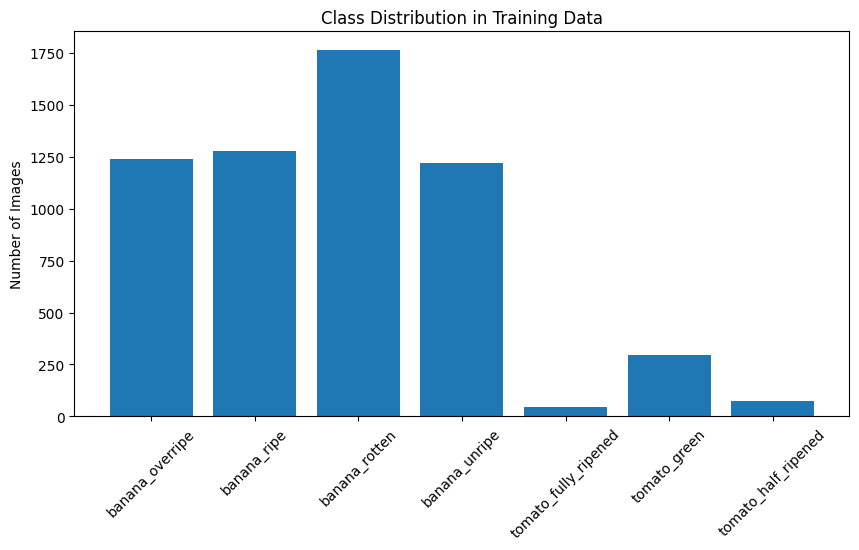

In [5]:
import numpy as np
import matplotlib.pyplot as plt

class_labels = trainData.classes

class_indices = trainData.class_indices

index_to_class = {v: k for k, v in class_indices.items()}

class_counts = np.bincount(class_labels)

total = len(class_labels)
print("Class Proportions (Train):")
for i, count in enumerate(class_counts):
    class_name = index_to_class[i]
    proportion = count / total
    print(f"{class_name}: {proportion:.2f}")

plt.figure(figsize=(10, 5))
plt.bar(index_to_class.values(), class_counts)
plt.title("Class Distribution in Training Data")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, Model



def convolutionBlock(x, filters, kernel_size=3, strides=1):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)

def residuals(x, filters, downsample=False):
    shortcut = x
    strides = 2 if downsample else 1

    x = convolutionBlock(x, filters, strides=strides)
    x = layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    if downsample or x.shape[-1] != shortcut.shape[-1]:
        shortcut = layers.Conv2D(filters, 1, strides=strides, use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    return layers.ReLU()(x)



def ResNet34(inputShape=(224, 224, 3), num_classes=7):
    
    inputs = layers.Input(shape=inputShape)
    x = convolutionBlock(inputs, 64, kernel_size=7, strides=2)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)


    aux_feature = None

    for filters, blocks, downsample in zip([64, 128, 256, 512], [3, 4, 6, 3], [False, True, True, True]):
        for i in range(blocks):
            x = residuals(x, filters, downsample=(i == 0 and downsample))
            
            if filters == 256 and i == 2: 
                aux_feature = x

    gap = layers.GlobalAveragePooling2D()(x)
    drop = layers.Dropout(0.05)(gap)
    main_output = layers.Dense(
        num_classes,
        activation='softmax',
        kernel_regularizer=tf.keras.regularizers.l2(0.001),
        name="main_output"
    )(drop)

    aux = layers.GlobalAveragePooling2D()(aux_feature)
    aux_output = layers.Dense(
        num_classes,
        activation='softmax',
        kernel_regularizer=tf.keras.regularizers.l2(0.001),
        name="aux_output"
    )(aux)

    return Model(inputs, outputs=[main_output, aux_output])


In [7]:
from tensorflow.keras import layers, regularizers, Model
# from tensorflow.keras.callbacks import EarlyStopping

# early_stop = EarlyStopping(
#     monitor='val_accuracy',     # you can use 'val_accuracy' as well
#     patience=7,             # number of epochs with no improvement after which training will be stopped
#     restore_best_weights=True  # restores the weights from the epoch with the best value of the monitored quantity
# )


base_model = ResNet34(inputShape=(224, 224, 3), num_classes=7)


x = base_model.get_layer("main_output").input  # this gets the input to main_output layer

x = layers.Dense(512, kernel_regularizer=regularizers.l2(0.0005))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)  # Slightly faster convergence than LeakyReLU in most cases
x = layers.Dropout(0.05)(x)  # Slightly reduced dropout

x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.0005))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.05)(x)

main_output = layers.Dense(7, activation='softmax', name="main_output")(x)

aux_output = base_model.get_layer("aux_output").output

# x = base_model.layers[-2].output  # or base_model.output if needed

# x = layers.Dense(512, kernel_regularizer=regularizers.l2(0.01))(x)
# x = layers.LeakyReLU(alpha=0.1)(x)
# x = layers.Dropout(0.5)(x)

# x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.01))(x)
# x = layers.LeakyReLU(alpha=0.1)(x)
# x = layers.Dropout(0.3)(x)

# outputs = layers.Dense(7, activation='softmax')(x)


# x = base_model.layers[-2].output  # or base_model.output if -2 doesn't fit your architecture
# x = layers.Dense(512, kernel_regularizer=regularizers.l2(0.01))(x)
# x = layers.BatchNormalization()(x)
# x = layers.LeakyReLU(alpha=0.1)(x)
# x = layers.Dropout(0.5)(x)

# x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.01))(x)
# x = layers.BatchNormalization()(x)
# x = layers.LeakyReLU(alpha=0.1)(x)
# x = layers.Dropout(0.3)(x)

# outputs = layers.Dense(7, activation='softmax')(x)

# x = base_model.layers[-2].output
# x = layers.Dense(512, activation='relu')(x)
# x = layers.Dropout(0.5)(x)
# x = layers.Dense(256, activation='relu')(x)
# x = layers.Dropout(0.3)(x)
# outputs = layers.Dense(7, activation='softmax')(x)

# x = base_model.layers[-2].output
# x = layers.Dense(256, activation='relu')(x)
# x = layers.Dropout(0.5)(x)
# outputs = layers.Dense(7, activation='softmax')(x)

finalModel = tf.keras.Model(inputs=base_model.input, outputs={
    "main_output": main_output,
    "aux_output": aux_output
})

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    alpha=1e-5
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

finalModel.compile(optimizer=optimizer,
                                loss={
                                'main_output': 'sparse_categorical_crossentropy',
                                'aux_output': 'sparse_categorical_crossentropy'
                                },
                                loss_weights={
                                    'main_output': 1.0,
                                    'aux_output': 0.4  # auxiliary loss gets lower weight
                                },
                                metrics={
                                'main_output': 'accuracy',
                                'aux_output': 'accuracy'
                                })

modelHistory=finalModel.fit(trainData, validation_data=valData, epochs=30,class_weight=class_weights)

finalModel.save_weights('/kaggle/working/ResNet34.weights.h5')


I0000 00:00:1747517442.689411      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747517442.690158      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'kernel', 'gamma', 'beta', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'bias', 'gamma', 'beta', 'bias', 'gamma', 'beta', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ig

  2/370 ━━━━━━━━━━━━━━━━━━━━ 33s 92ms/step - aux_output_accuracy: 0.1875 - loss: 1.8600   

I0000 00:00:1747517477.889457     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


370/370 ━━━━━━━━━━━━━━━━━━━━ 145s 303ms/step - aux_output_accuracy: 0.4622 - loss: 0.7729 - val_aux_output_accuracy: 0.4120 - val_loss: 0.6472
Epoch 2/30
370/370 ━━━━━━━━━━━━━━━━━━━━ 64s 170ms/step - aux_output_accuracy: 0.6928 - loss: 0.3915 - val_aux_output_accuracy: 0.6049 - val_loss: 0.5567
Epoch 3/30
370/370 ━━━━━━━━━━━━━━━━━━━━ 65s 172ms/step - aux_output_accuracy: 0.7650 - loss: 0.3056 - val_aux_output_accuracy: 0.2788 - val_loss: 0.9863
Epoch 4/30
370/370 ━━━━━━━━━━━━━━━━━━━━ 68s 180ms/step - aux_output_accuracy: 0.7927 - loss: 0.3115 - val_aux_output_accuracy: 0.4005 - val_loss: 1.1906
Epoch 5/30
370/370 ━━━━━━━━━━━━━━━━━━━━ 65s 174ms/step - aux_output_accuracy: 0.8185 - loss: 0.2765 - val_aux_output_accuracy: 0.1150 - val_loss: 1.9708
Epoch 6/30
370/370 ━━━━━━━━━━━━━━━━━━━━ 66s 174ms/step - aux_output_accuracy: 0.8273 - loss: 0.2753 - val_aux_output_accuracy: 0.7037 - val_loss: 0.3340
Epoch 7/30
370/370 ━━━━━━━━━━━━━━━━━━━━ 65s 172ms/step - aux_output_accuracy: 0.8065 - loss:

In [10]:
finalModel.save('/kaggle/working/ResNet34Model.h5')


In [12]:
from tensorflow.keras.models import load_model

ResNetModel_loaded = load_model('/kaggle/working/ResNet34Model.h5')

# finalModel.load_weights('/kaggle/working/ResNet34.weights.h5')

test_loss, test_accuracy = ResNetModel_loaded.evaluate(valData)
print(f"Test Accuracy: {test_accuracy:.4f}")


93/93 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - aux_output_accuracy: 0.9456 - loss: 0.0692
Test Accuracy: 0.9317


In [16]:
import pandas as pd

# predicted_classes = tf.argmax(finalModel.predict(testData), axis=1)
preds = finalModel.predict(testData)

main_preds = preds['main_output']
predicted_classes = tf.argmax(main_preds, axis=1).numpy()

filenames = testData.filenames

df_predictions = pd.DataFrame({
    'ImageID': [os.path.basename(f) for f in filenames],
    'Class': predicted_classes
})


df_predictions.to_csv('/kaggle/working/resnet.csv', index=False)

156/156 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step


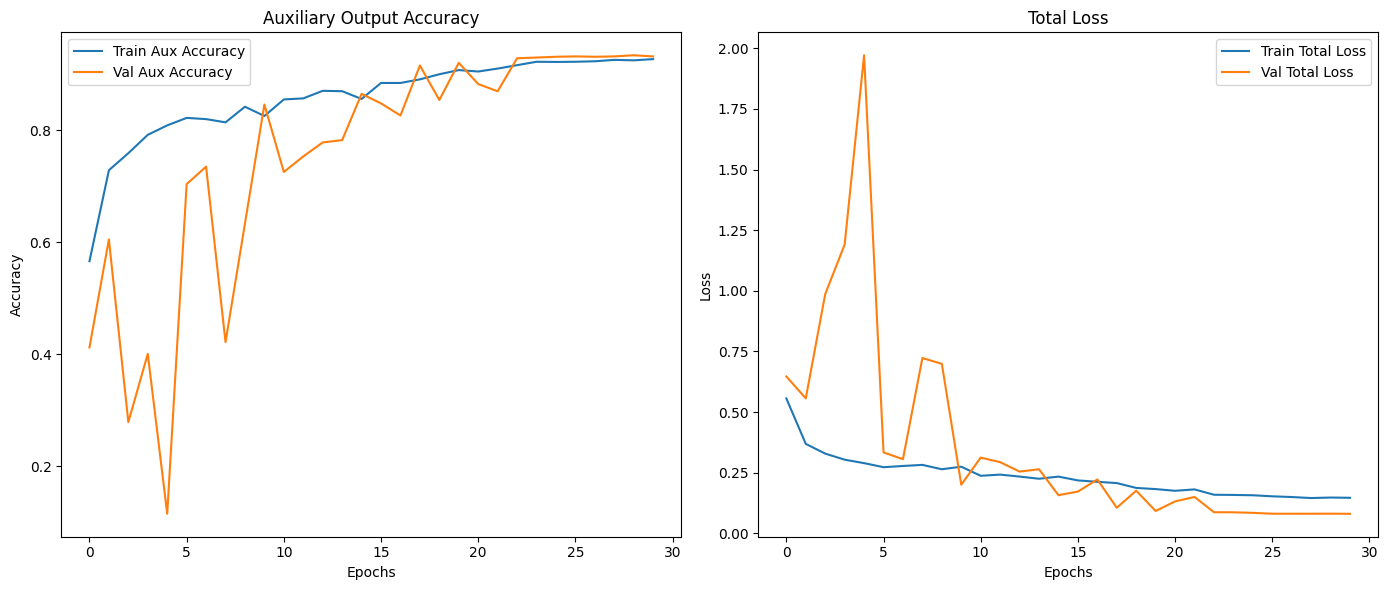

In [15]:
import matplotlib.pyplot as plt

# Extract available metrics
aux_acc = modelHistory.history['aux_output_accuracy']
val_aux_acc = modelHistory.history['val_aux_output_accuracy']
loss = modelHistory.history['loss']
val_loss = modelHistory.history['val_loss']

epochs_range = range(len(aux_acc))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, aux_acc, label='Train Aux Accuracy')
plt.plot(epochs_range, val_aux_acc, label='Val Aux Accuracy')
plt.title('Auxiliary Output Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Total Loss')
plt.plot(epochs_range, val_loss, label='Val Total Loss')
plt.title('Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
